In [1]:
import pandas as pd
import os
from tqdm import tqdm
import concurrent.futures

dff = pd.read_csv('./twcs.csv')

In [2]:
dff['company'] = dff['author_id'].str.lower()
dff['created_at'] = pd.to_datetime(dff['created_at'])
dff.set_index('tweet_id', inplace=True)
dff['in_response_to_tweet_id'] = dff['in_response_to_tweet_id'].astype('Int64')
dff = dff.sort_index(ascending=True)

dff['text'] = dff['text'].apply(lambda t: " ".join(t.split())) # Remove all line breaks, tabs etc from the text column

In [133]:
dff.shape

(2811774, 8)

In [25]:
dff.head(5)

,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company
tweet_id,,,,,,,
1,sprintcare,False,2017-10-31 22:10:47+00:00,@115712 I understand. I would like to assist y...,2,3,sprintcare
2,115712,True,2017-10-31 22:11:45+00:00,@sprintcare and how do you propose we do that,NaN,1,115712
3,115712,True,2017-10-31 22:08:27+00:00,@sprintcare I have sent several private messag...,1,4,115712
4,sprintcare,False,2017-10-31 21:54:49+00:00,@115712 Please send us a Private Message so th...,3,5,sprintcare
5,115712,True,2017-10-31 21:49:35+00:00,@sprintcare I did.,4,6,115712


In [ ]:
# Assign Conversation Numbers - Original non-parallelised code - Too slow 12 it/s
df = dff.head(2000)
def find_conv(resp_id, idx):
    flag = True
    while flag:
        new_idx = resp_id[resp_id.isin(idx)].index
        new_idx = set(new_idx).union(idx)
        flag = len(new_idx) - len(idx)
        idx = list(new_idx)
    return idx 

conv_idx = df[pd.isna(df['in_response_to_tweet_id'])].index
df.loc[conv_idx, 'conversation'] = conv_idx.values

conv_dict = dict()
for conv in tqdm(conv_idx):
    idx = find_conv(df['in_response_to_tweet_id'], [conv])
    conv_dict[conv] = idx

for conv, idx in conv_dict.items():
    df.loc[idx, 'conversation'] = conv
df['conversation'] = df['conversation'].astype('int')
df.tail(10)

In [41]:
# Assign conversation numbers - parallelised - Chunk of conversations - ok speed (chunk_size 10k~1.3k it/s, 50k~1.5k it/s, 500~ max speed 2.5k it/s)
#df = dff

def find_conv(resp_id, idx):
    flag = True
    while flag:
        new_idx = resp_id[resp_id.isin(idx)].index
        new_idx = set(new_idx).union(idx)
        flag = len(new_idx) - len(idx)
        idx = list(new_idx)
    return idx

# Function to process each conversation
def process_conversation(conv, df):
    idx = find_conv(df['in_response_to_tweet_id'], [conv])
    return conv, idx

def get_conversations(dff, chunk_size):
    # # Parallelize the loop using concurrent.futures
    # with concurrent.futures.ThreadPoolExecutor(max_workers=num_cores) as executor:
    #     results = list(tqdm(executor.map(process_conversation, conv_idx), total=len(conv_idx)))

    conv_idx = dff[pd.isna(dff['in_response_to_tweet_id'])].index
    # Get the number of available CPU cores
    num_cores = min(len(conv_idx), os.cpu_count())
    # Print the number of cores used
    print("Number of cores used:", num_cores)

    # Parallelize the loop using concurrent.futures
    results = []
    start_idx = 0
    for i in range(len(conv_idx)//chunk_size):
        end_idx = conv_idx[min(len(conv_idx), (i+1)*chunk_size)]
        chunk_idx = conv_idx[i*chunk_size:min(len(conv_idx), (i+1)*chunk_size)]
        if len(chunk_idx) == chunk_size:
            df = dff.loc[dff.index.isin(list(range(start_idx,end_idx)))]
        if len(chunk_idx) < chunk_size:
            df = dff.loc[start_idx:]
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_cores) as executor:
            temp = list(tqdm(executor.map(process_conversation, chunk_idx, [df]*len(chunk_idx)), total=len(chunk_idx)))
        results += temp
        start_idx = end_idx
    return results

In [42]:
# Update the 'conversation' values in the DataFrame
chunk_size = 10000
results = get_conversations(dff, chunk_size)
for conv, idx in results:
    dff.loc[idx, 'conversation'] = conv

dff['conversation'] = dff['conversation'].astype('Int64')

Number of cores used: 10


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1580.77it/s]


In [45]:
missed = dff[dff['conversation'].isna()]
missed_resp_id = missed['in_response_to_tweet_id'].values
idx = list(set(missed_resp_id).intersection(dff.index))
missed_resp = dff.loc[idx]
newdf = pd.concat([missed, missed_resp]).sort_index(ascending=True).drop_duplicates()

missed_conv_idx = newdf[pd.isna(newdf['in_response_to_tweet_id'])].index
results_missed = []
for conv in tqdm(missed_conv_idx):
    idx = find_conv(newdf['in_response_to_tweet_id'], [conv])
    results_missed.append((conv, idx))

for conv, idx in results_missed:
    dff.loc[idx, 'conversation'] = conv

dff['conversation'] = dff['conversation'].astype('Int64')

Number of cores used: 10


In [174]:
dff.tail(10)

,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company,conversation
tweet_id,,,,,,,,
2987941,AirAsiaSupport,False,2017-11-22 07:55:05+00:00,@823867 we have replied you via DM.Thanks-Emir,NaN,2987942,airasiasupport,2987942
2987942,823867,True,2017-11-22 07:30:39+00:00,Hai @AirAsiaSupport #asking how many days need...,2987941,<NA>,airasiasupport,2987942
2987943,AirAsiaSupport,False,2017-11-22 07:54:57+00:00,"@823868 Sorry but kindly try to clear browser,...",NaN,2987944,airasiasupport,2987944
2987944,823868,True,2017-11-22 07:43:36+00:00,@AirAsiaSupport I am unable to do web checkin....,2987943,<NA>,airasiasupport,2987944
2987945,VirginTrains,False,2017-11-22 08:27:34+00:00,@524544 That's a Peak service. The 09:56 is th...,NaN,2987946,virgintrains,2987946
2987946,524544,True,2017-11-22 08:25:48+00:00,@VirginTrains Hope you are well? Does the 9.30...,2987945,<NA>,virgintrains,2987946
2987947,sprintcare,False,2017-11-22 08:43:51+00:00,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948,sprintcare,2987948
2987948,823869,True,2017-11-22 08:35:16+00:00,@115714 wtf!? I’ve been having really shitty s...,2987947,<NA>,sprintcare,2987948
2987949,AldiUK,False,2017-11-22 08:31:24+00:00,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950,aldiuk,2987950


In [108]:
# Assign Company to conversations

def process_group(group_tuple):
    group_name, group_data = group_tuple
    grp_idx = group_data.index
    companies = [n.lower() for n in group_data['author_id'].unique() if not n.isnumeric()]
    # It is possible that multiple companies got involved into the same conversation, often both merchant and logistic company.
    return ', '.join(sorted(companies)), grp_idx
    # if len(authors) == 1:
    #     company = authors[0]
    #     return company, grp_idx
    # else:
    #     print('Conversation {} has more than one company: {}'.format(group_name, authors))
    #     return None

# Your existing code...
idxGroup = dict()
grouped = dff.groupby('conversation')


for group in tqdm(grouped):
    company, grp_idx = process_group(group)
    if company in idxGroup:
        idxGroup[company].extend(grp_idx)
    else:
        idxGroup[company] = list(grp_idx)    


# Assign the 'company' values to the DataFrame
for company, idx in idxGroup.items():
    dff.loc[list(set(idx)), 'company'] = company


100%|████████████████████████████████████████████████████████████████████████| 794335/794335 [00:28<00:00, 27398.09it/s]


In [109]:
dff.loc[dff['conversation']==2979681]

,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,company,conversation
tweet_id,,,,,,,,
2979680,AmazonHelp,False,2017-11-30 04:08:00+00:00,@249801 Please reach out to us by phone or cha...,NaN,2979681,"amazonhelp, upshelp",2979681
2979681,249801,True,2017-11-30 03:58:22+00:00,"Hey @115817, thanks for not delivering my pack...","2979680,2979682",<NA>,"amazonhelp, upshelp",2979681
2979682,UPSHelp,False,2017-11-30 04:25:28+00:00,@249801 I am sorry to hear that your package w...,2980530,2979681,"amazonhelp, upshelp",2979681
2980530,221581,True,2017-11-30 04:45:53+00:00,@UPSHelp @249801 Dont feel too bad. I have a N...,2980531,2979682,"amazonhelp, upshelp",2979681
2980531,249801,True,2017-11-30 04:49:13+00:00,@221581 @UPSHelp wow that sucks. Hope you get ...,2980532,2980530,"amazonhelp, upshelp",2979681
2980532,221581,True,2017-11-30 04:51:37+00:00,@249801 @UPSHelp I am lucky that Amazon does t...,NaN,2980531,"amazonhelp, upshelp",2979681


In [169]:
# Save the processed data as csv
dff.to_csv('twcs_proccessed.csv')

In [186]:
from collections import Counter
for c, v in Counter(dff['company']).most_common(20):
    cdates = dff.loc[dff['company'] == c].created_at
    print(c, v, cdates.min().year, cdates.max().year)

amazonhelp 366422 2011 2017
applesupport 235734 2013 2017
uber_support 126557 2014 2017
spotifycares 90729 2013 2017
delta 85005 2012 2017
americanair 84201 2011 2017
tmobilehelp 75427 2012 2017
comcastcares 69917 2014 2017
tesco 69747 2014 2017
virgintrains 64074 2012 2017
southwestair 62694 2008 2017
british_airways 58984 2012 2017
ask_spectrum 56671 2010 2017
xboxsupport 54284 2012 2017
sprintcare 47645 2011 2017
hulu_support 47242 2014 2017
gwrhelp 45219 2013 2017
atviassist 44730 2014 2017
askplaystation 42511 2010 2017
chipotletweets 41192 2012 2017


In [228]:
# Select a subset based on company for demonstration

sel_company = ['americanair', 'british_airways', 'spotifycares', 'comcastcares']
sel_df = dff.loc[dff['company'].isin(sel_company)]
sel_df = sel_df[(sel_df['created_at'].dt.month == 10) & (sel_df['created_at'].dt.year == 2017) |
                 (sel_df['created_at'].dt.month == 11) & (sel_df['created_at'].dt.year == 2017)]
sel_df['created_at'] = sel_df['created_at'].dt.tz_localize(None)
sel_df.dropna(subset='conversation', inplace=True)
sel_df.company.unique()
sel_df.to_csv('twcs_sel.csv')

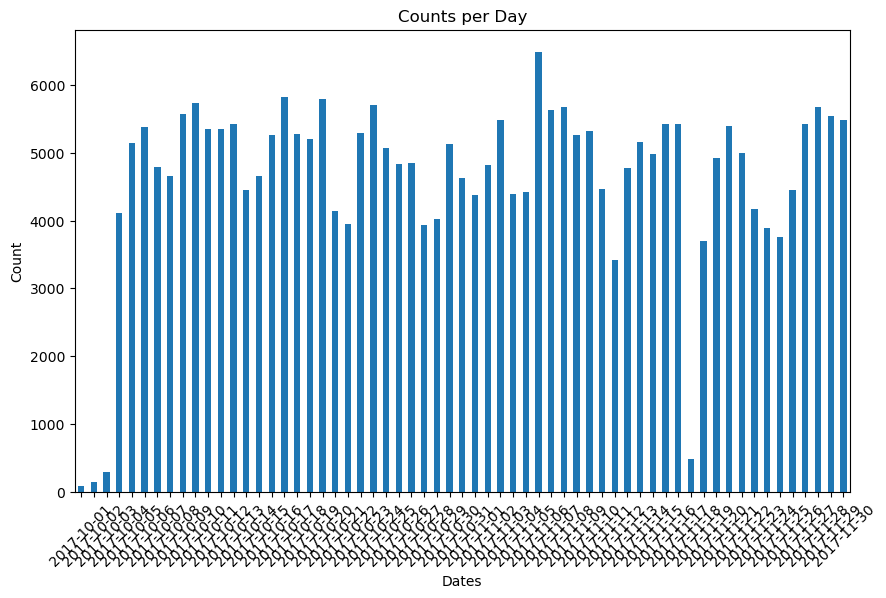

In [227]:
import matplotlib.pyplot as plt
df = pd.DataFrame()
df['date'] = sel_df['created_at'].dt.to_period('D')

# Group the data by year and month and calculate the count
counts_per_year_month = df.groupby('date').size()

# Plot the histogram
counts_per_year_month.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Dates')
plt.ylabel('Count')
plt.title('Counts per Day')
plt.xticks(rotation=45)
plt.show()

## No use

In [ ]:
# Assign conversation numbers - parallelised - very slow ~100it/s
df = dff

def find_conv(resp_id, idx):
    flag = True
    while flag:
        new_idx = resp_id[resp_id.isin(idx)].index
        new_idx = set(new_idx).union(idx)
        flag = len(new_idx) - len(idx)
        idx = list(new_idx)
    return idx

conv_idx = df[pd.isna(df['in_response_to_tweet_id'])].index
df.loc[conv_idx, 'conversation'] = conv_idx.values

# Function to process each conversation
def process_conversation(conv):
    idx = find_conv(df['in_response_to_tweet_id'], [conv])
    return conv, idx

# Get the number of available CPU cores
num_cores = min(len(conv_idx), os.cpu_count())
# Print the number of cores used
print("Number of cores used:", num_cores)

# Parallelize the loop using concurrent.futures
with concurrent.futures.ThreadPoolExecutor(max_workers=num_cores) as executor:
    results = list(tqdm(executor.map(process_conversation, conv_idx), total=len(conv_idx)))

# Update the 'conversation' values in the DataFrame
for conv, idx in results:
    df.loc[idx, 'conversation'] = conv

df['conversation'] = df['conversation'].astype('Int64')
